In [11]:
# Load all the global modules 
import numpy as np
import torch as T
import pytorch_lightning as pl
import hydra
from omegaconf import OmegaConf
from pathlib import Path
import pandas as pd
import h5py
import matplotlib.pyplot as plt

In [ ]:
# Local imports
import pyrootutils
import os
root = pyrootutils.setup_root(search_from=os.path.abspath(''), pythonpath=True, cwd=True, indicator=".project-root")
from transit.src.utils.hydra_utils import reload_original_config

In [7]:
# Get hydra configs
config_file = "/home/users/o/oleksiyu/WORK/weakly-supervised-search/user_job_runs/full_analysis_validation_1KHa12_d1903/transit/full_config.yaml"
cfg = OmegaConf.load(config_file)
print(cfg)

{'step_train_template': {'model': {'reverse_pass_mode': 'additional_input', 'network_type': 'partial_context', '_target_': 'transit.src.models.transit_model.TRANSIT', 'use_m_encodig': True, 'encoder_cfg': {'_target_': 'transit.mattstools.mattstools.modules_myy.DenseNetwork', '_partial_': True, 'act_h': 'silu', 'act_i': 'none', 'nrm': 'none', 'hddn_dim': 128, 'num_blocks': 3, 'n_lyr_pbk': 2, 'do_res': True, 'scale_output_hidden': 1.0, 'ctxt_in_inpt': True, 'ctxt_in_hddn': True, 'ctxt_in_out': False}, 'decoder_cfg': {'_target_': 'transit.mattstools.mattstools.modules_myy.DenseNetwork', '_partial_': True, 'act_h': 'silu', 'act_i': 'none', 'nrm': 'none', 'hddn_dim': 128, 'num_blocks': 3, 'n_lyr_pbk': 2, 'do_res': True, 'scale_output_hidden': 1.0, 'ctxt_in_inpt': True, 'ctxt_in_hddn': True, 'ctxt_in_out': False}, 'latent_norm': False, 'latent_dim': 8, 'loss_cfg': {'reco': {'w': 1}, 'consistency_x': {'w': 0.1}}, 'adversarial_cfg': {'mode': 'double_discriminator_priority', 'discriminator2': {

In [10]:
# Get the training dataset
datamodule = hydra.utils.instantiate(cfg.data.template_training)
datamodule.setup(stage="fit")
train_dataloader = datamodule.train_dataloader()
batch = next(iter(train_dataloader))
print("Sample batch from training dataset:", batch)

Loaded dataset cond from /home/users/o/oleksiyu/WORK/weakly-supervised-search/user_job_runs/full_analysis_validation_1KHa12_d1903/transit/../data/data/sb.h5
Loaded dataset data from /home/users/o/oleksiyu/WORK/weakly-supervised-search/user_job_runs/full_analysis_validation_1KHa12_d1903/transit/../data/data/sb.h5
Loaded dataset is_signal from /home/users/o/oleksiyu/WORK/weakly-supervised-search/user_job_runs/full_analysis_validation_1KHa12_d1903/transit/../data/data/sb.h5
Loaded dataset orig from /home/users/o/oleksiyu/WORK/weakly-supervised-search/user_job_runs/full_analysis_validation_1KHa12_d1903/transit/../data/data/sb.h5
Loaded dataset cond from ['/home/users/o/oleksiyu/WORK/weakly-supervised-search/user_job_runs/full_analysis_validation_1KHa12_d1903/transit/../data/data/sb.h5', '/home/users/o/oleksiyu/WORK/weakly-supervised-search/user_job_runs/full_analysis_validation_1KHa12_d1903/transit/../data/data/sr.h5']
Loaded dataset data from ['/home/users/o/oleksiyu/WORK/weakly-supervise

(array([203., 192., 153., 132., 120., 109.,  89.,  95.,  95.,  81.,  66.,
         56.,  67.,  44.,  40.,  49.,  41.,  41.,  30.,  36.,  29.,  21.,
         22.,  28.,  18.,  30.,  22.,  25.,  12.,  14.,   9.,  16.,  13.,
          7.,  11.,   7.,   8.,   3.,   8.,   6.]),
 array([4.58129478e-04, 2.54082438e-02, 5.03583588e-02, 7.53084719e-02,
        1.00258589e-01, 1.25208706e-01, 1.50158823e-01, 1.75108939e-01,
        2.00059056e-01, 2.25009173e-01, 2.49959275e-01, 2.74909407e-01,
        2.99859524e-01, 3.24809641e-01, 3.49759728e-01, 3.74709845e-01,
        3.99659961e-01, 4.24610078e-01, 4.49560195e-01, 4.74510312e-01,
        4.99460429e-01, 5.24410546e-01, 5.49360693e-01, 5.74310780e-01,
        5.99260867e-01, 6.24211013e-01, 6.49161100e-01, 6.74111247e-01,
        6.99061334e-01, 7.24011481e-01, 7.48961568e-01, 7.73911715e-01,
        7.98861802e-01, 8.23811948e-01, 8.48762035e-01, 8.73712182e-01,
        8.98662269e-01, 9.23612416e-01, 9.48562503e-01, 9.73512650e-01,
      

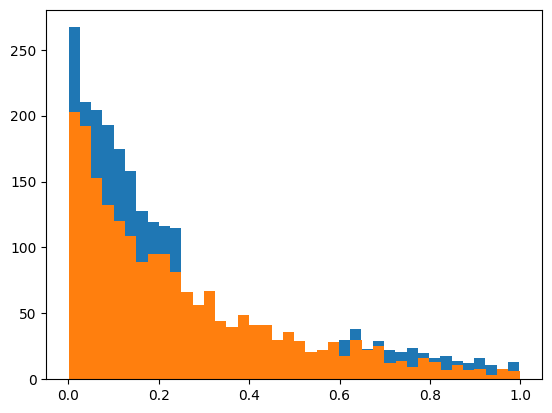

In [14]:
plt.hist(batch[1].numpy(), bins=40)
plt.hist(batch[2].numpy(), bins=40)

In [17]:
# Load the model from the last checkpoint
device = "cuda" if T.cuda.is_available() else "cpu"
model_class = hydra.utils.get_class(cfg.step_train_template.model._target_)
model = model_class.load_from_checkpoint("/home/users/o/oleksiyu/WORK/weakly-supervised-search/user_job_runs/full_analysis_validation_1KHa12_d1903/transit/template/checkpoints/last.ckpt", map_location=device)
model.eval()
print(model)

SELECTED NETWORK TYPE:  partial_context
Dequantization layer added
TRANSIT(
  (encoder1): 
    (inp): 7(1)->Linear->128
    (h-1): 128(1)->Linear->SiLU->Linear->SiLU->Scaling->128(add)
    (h-2): 128(1)->Linear->SiLU->Linear->SiLU->Scaling->128(add)
    (out): 128->Linear->8
  (decoder): 
    (inp): 8(1)->Linear->128
    (h-1): 128(1)->Linear->SiLU->Linear->SiLU->Scaling->128(add)
    (h-2): 128(1)->Linear->SiLU->Linear->SiLU->Scaling->128(add)
    (out): 128->Linear->7
  (discriminator2): 
    (inp): 7(1)->Linear->PReLU->64
    (h-1): 64(1)->Linear->PReLU->64
    (h-2): 64(1)->Linear->PReLU->64
    (h-3): 64(1)->Linear->PReLU->64
    (out): 64->Linear->Sigmoid->1
  (std_layer_x): IterativeNormLayer([1, 7])
  (std_layer_ctxt): IterativeNormLayer([1, 1])
  (dequantization_layer): SelectiveDequantizationTransform()
  (DisCO_loss): DistanceCorrelation()
  (pearson_loss): PearsonCorrelation()
)


In [29]:
out = model._shared_step(batch, step_type="valid")

/home/users/o/oleksiyu/.local/lib/python3.11/site-packages/pytorch_lightning/core/module.py:436: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


In [26]:
out

(tensor(1.5198e-05, grad_fn=<AddBackward0>),
 tensor([[-0.3915,  0.2159, -0.1910,  ..., -1.3700,  1.2516,  0.3398],
         [-0.2256, -0.0346,  0.8602,  ...,  1.6060, -1.1756,  2.5226],
         [ 1.0225, -0.3291,  0.7053,  ..., -0.9519,  0.7124, -0.6403],
         ...,
         [-0.1372, -1.3162,  0.7488,  ...,  1.1636, -0.9896,  1.6429],
         [-0.5244,  0.3124, -0.0610,  ..., -0.5707,  0.9145,  2.1415],
         [-0.2744,  0.4524, -0.0401,  ..., -0.0160,  0.2629,  0.1750]],
        grad_fn=<AddmmBackward0>),
 tensor([[ 1.7368],
         [ 2.9944],
         [ 1.7417],
         ...,
         [-0.9351],
         [ 1.7815],
         [-0.1620]]),
 tensor([[-1.4234,  0.4353, -0.3046,  ..., -1.5390,  0.1947,  1.6263],
         [ 3.8136,  2.6919,  5.0876,  ...,  0.1576, -0.6521, -0.2882],
         [-1.4712, -0.6806, -0.4581,  ...,  0.2180, -0.6552,  1.7716],
         ...,
         [ 1.2199,  0.3824,  1.2230,  ...,  0.7464, -0.2479, -1.6310],
         [ 0.5291,  2.7273,  1.2017,  ..., -1